In [96]:
import ODESolve
import ipywidgets as widgets
import numba as nb
import numpy as np
import derivatives as der
import interp
import simp_spreading as cv
import coll_varbins as cvv
import Collision_approx as ca
import os
import shutil
import RunSterileDecay as RSD
import matplotlib.pyplot as plt
import nu_nu_collisions as coll
from Constants import mpi_neutral

from var_param import f_TINY, f_MINI, f_SMALL, f_BUFFER, MIN_eps_BUFFER, a_MAXMULT, eps_small_MAX, len_y_MAX, small_boxsize, eps_small_box, num_small_boxes, initial_boxsize


@nb.njit()
def infl(k):
    return int(np.round(k,0))

@nb.njit()
def find_breaks(f, E5_index = 0, E2_index = 0):
    k = np.ones(3) * (len(f) - 1)
    
    if (len(np.where(f < f_TINY)[0]) > 0):
        k[0] = np.where(f < f_TINY)[0][0]
    if (len(np.where(f < f_MINI)[0]) > 0):
        k[1] = np.where(f < f_MINI)[0][0]
    if (len(np.where(f < f_SMALL)[0]) > 0):
        k[2] = np.where(f < f_SMALL)[0][0]
    
    for i in range(infl(k[0]), len(f)):
        if f[i] > f_TINY:
            k[0] = i+1
    for i in range(infl(k[1]), len(f)):
        if f[i] > f_MINI:
            k[1] = i+1
    for i in range(infl(k[2]),len(f)):
        if f[i] > f_SMALL:
            k[2] = i+1

    for j in range(3):
        for i in [E5_index, E2_index]:
            if i - MIN_eps_BUFFER < k[j] <= i:
                k[j] += 2 * MIN_eps_BUFFER
            if i <= k[j] < i + MIN_eps_BUFFER:
                k[j] += MIN_eps_BUFFER
        for jj in range(j+1,3):
            if k[jj] < k[j] + MIN_eps_BUFFER:
                k[jj] = k[j] + MIN_eps_BUFFER
        if k[j] >= len(f):
            k[j] = len(f) - 1
    return k

@nb.njit()
def make_p(a0, eps, f, p_fix, A_model, n_model):
    len_eps = len(eps)
    p = np.zeros(len_eps + 11)
    p[:len_eps] = eps
    p[-4:] = p_fix
    p[-10] = len_eps
    p[-11] = eps[-1] - eps[-2]
    
    p[-8] = A_model
    p[-9] = n_model
    
    ms = p_fix[-1]
    EB5 = ms/2
    EB2 = (ms**2 - mpi_neutral**2)/(2*ms)
    
    p[-7:-4] = find_breaks(f, E5_index = np.where(eps < EB5 * a0)[0][-1], E2_index = np.where(eps < EB2 * a0)[0][-1])
    
    return p

@nb.njit()
def find_a_MAX(a0, t, p):
    ms = p[-1]
    tau = p[-2]
    D = p[-3]
    len_eps = infl(p[-10])
    deps_last = p[-11]
    
    EB5 = ms/2
    EB2 = (ms**2 - mpi_neutral**2)/(2*ms)
    
    
    f_FULL = 2 * np.pi**2 * der.nH(t, 1/a0, p[-2], p[-3]) / ( 1/a0 * EB5**2 * deps_last )
    decay_on = True
    
    if f_FULL < f_BUFFER:
        decay_on = False
        
    a_max = a0 * a_MAXMULT
    
    if decay_on:
        a_max = min(a_max, p[len_eps - 2 * MIN_eps_BUFFER - 1] / EB2)
    
    return a_max, decay_on

@nb.njit()
def driver(a0, eps0, y0, dx0, N_steps, dN, A_model, n_model, p_fix):
    a_MAX, decay_on = find_a_MAX(a0, y0[-1], make_p(a0, eps0, y0[:-2], p_fix, A_model, n_model))
    
    a = a0
    eps = np.copy(eps0)
    y = np.copy(y0)
    dx = dx0
    
    out_a = np.zeros(N_steps+1)
    out_y = np.zeros((N_steps+1, len(y0)))
    out_dx = np.zeros(N_steps+1)
    
    last_ind = N_steps
    
    eps_small = np.where(y0[:-2] > f_SMALL)[0][-1]
    eps_buffer = np.where(y0[:-2] > f_BUFFER)[0][-1]
    
    out_a[0] = a0
    out_y[0,:] = y0
    out_dx[0] = dx0
    
    for ns in range(N_steps):
        params = make_p(a, eps, y[:-2], p_fix, A_model, n_model)
                
        ode_out = ODESolve.ODEOneRun(a, y, dx, params, 1, dN, a_MAX)
        
        a = ode_out[0][-1]
        dx = ode_out[2][-1]
        y = np.copy(ode_out[1][-1])
        
        out_a[ns+1] = a
        out_y[ns+1][:] = y
        out_dx[ns+1] = dx
        
        if ode_out[3]:
            last_ind = ns + 1
            break
            
        eps_check = np.where(y[:-2] > f_SMALL)[0][-1]  
        if eps_check - eps_small > (eps_buffer - eps_small) / 2:
            last_ind = ns + 1
            break

            
    
    return out_a[:(last_ind+1)], out_y[:(last_ind+1),:], out_dx[:(last_ind+1)], decay_on

@nb.njit()
def forward(mH, y_v, e_array, a, decay_on):
    eps_small_new = np.where(y_v[:-2] > f_SMALL)[0][-1]
    xp = np.zeros(2)
    yp = np.zeros(2)
    kk = 0
    while (yp[1] >= yp[0]):
        if eps_small_new + kk >= len(e_array):
            break
        else:
            for i in range(2):
                yp[i] = y_v[eps_small_new + kk + i - 1]
                xp[i] = e_array[eps_small_new + kk + i - 1]
            kk += 1
            
    if eps_small_new + kk == len(e_array):
        print("f is increasing at last box?")
        return y_v, e_array
    
    eps_small_new = eps_small_new + kk
    bxsz = abs(xp[1] - xp[0])
    new_len = len(y_v)
    if y_v[eps_small_new] < f_BUFFER:
        new_len = eps_small_new
    else:
        if decay_on:
            e_up = np.where(e_array < 0.5 * mH * a)[0][-1]
            if e_up > len(e_array) - 2 * MIN_eps_BUFFER:
                e_up += MIN_eps_BUFFER * 3
            e_test = e_array[eps_small_new-1] + (new_len - (MIN_eps_BUFFER + 1) - eps_small_new) * bxsz
            while (e_test - 3*MIN_eps_BUFFER * bxsz)/a <= 0.5 * mH:
                e_up += MIN_eps_BUFFER
                e_test = e_array[eps_small_new-1] + (e_up - (MIN_eps_BUFFER + 1) - eps_small_new) * bxsz
            
            e_temp = max(eps_small_new, e_up)
        else:
            e_temp = eps_small_new
            
        if e_temp > len(y_v) - 5:
            new_len = e_temp
            
            eps_small_new = np.where(y_v[:-2] > np.sqrt(f_SMALL*f_BUFFER))[0][-1]
            yp[0] = y_v[eps_small_new-1]
            yp[1] = y_v[eps_small_new]
            xp[0] = e_array[eps_small_new-1]
            xp[1] = e_array[eps_small_new]
            
            while yp[1] > yp[0]:
                eps_small_new += 2
                yp[0] = y_v[eps_small_new-1]
                yp[1] = y_v[eps_small_new]
                xp[0] = e_array[eps_small_new-1]
                xp[1] = e_array[eps_small_new]
                
        else:
            if y_v[e_temp] < f_BUFFER:
                new_len = e_temp
                eps_small_new = e_temp
            else:
                new_len = e_temp
                
                yp[0] = y_v[e_temp]
                yp[1] = y_v[e_temp+1]
                xp[0] = e_array[e_temp]
                xp[1] = e_array[e_temp+1]
                e_extrap = e_temp

                while e_temp < len(y_v) - 5:
                    if y_v[e_temp] < f_BUFFER:
                        break
                    if y_v[e_temp+1] < y_v[e_temp] and yp[1]/yp[0] > y_v[e_temp+1]/y_v[e_temp]:
                        yp[0] = y_v[e_temp]
                        yp[1] = y_v[e_temp+1]
                        xp[0] = e_array[e_temp]
                        xp[1] = e_array[e_temp+1]
                        e_extrap = e_temp
                    e_temp += 2
                
                for i in range(20*eps_small_new):
                    if interp.log_linear_extrap(xp[0] + i * bxsz, xp, yp) > f_BUFFER:
                        new_len = i + e_extrap
                    else:
                        break
                    
                eps_small_new = e_extrap
    y = np.zeros(new_len+2)
    y[-1] = y_v[-1]
    y[-2] = y_v[-2]
    eps_array = np.zeros(new_len)
    for i in range(eps_small_new):
        eps_array[i] = e_array[i]
        y[i] = y_v[i]
    if len(eps_array) > eps_small_new:
        for i in range(eps_small_new, len(eps_array)):
            eps_array[i] = e_array[eps_small_new-1] + (i+1 - eps_small_new) * bxsz
            y[i] = interp.log_linear_extrap(eps_array[i], xp, yp)

    return y, eps_array

def nextstep(a0, eps0, y0, dx0, N_steps, dN, p_fix, fn, nr):
    
    input_filename = fn + "/inputs-{}".format(nr)
    output_filename = fn + "/full-{}".format(nr)
    
    A_model, n_model = ca.model_An(a0, y0[-2])

    np.savez(input_filename,ms=p_fix[-1],mixangle=p_fix[-4],a0=a0,y0=y0,dx0=dx0,e_array=eps0,A_model=A_model,n_model=n_model)
    
    result = driver(a0, eps0, y0, dx0, N_steps, dN, A_model, n_model, p_fix)
    
    np.savez(output_filename,ms=p_fix[-1],mixangle=p_fix[-4],a=result[0],y=result[1],dx=result[2],eps=eps0)
    
    y_next, eps_next = forward(p_fix[-1], result[1][-1], eps0, result[0][-1], result[3])
    
    return result[0][-1], eps_next, y_next, result[2][-1]


def run_code(a0, eps0, y0, dx0, p_fix, temp_fin, folder_name):
    a = a0
    eps = np.copy(eps0)
    y = np.copy(y0)
    dx = dx0
    for i in range(200):
        a, eps, y, dx = nextstep(a, eps, y, dx, 100, 100, p_fix, folder_name, i)
        
        eps_small = np.where(y[:-2] > f_SMALL)[0][-1]
        if eps_small > eps_small_MAX or len(y) > len_y_MAX:
            y, eps = cv.simple_spread_eps(y, eps)
            
        if y[-2] < temp_fin:
            break

def run_code_error(folder_name, inputs_file):    
    in_npz = np.load("{}/{}".format(folder_name,inputs_file))
    a = float(in_npz['a0'])
    y = in_npz['y0']
    eps = in_npz['e_array']
    dx = float(in_npz['dx0'])
    
    p_fix = make_p_fixed(float(in_npz['ms']), float(in_npz['mixangle']), 1/1.79**3)

    fn = "{}/debug".format(folder_name)    
    if not os.path.exists(fn):
        os.makedirs(fn)
    else:
        print("Folder {} already exists.  Overwriting any data".format(fn))
        
    shutil.copy("{}/{}".format(folder_name,inputs_file), "{}/debug/original-{}".format(folder_name, inputs_file))


    for i in range(200):
        a, eps, y, dx = nextstep(a, eps, y, dx, 10, 5, p_fix, fn, i)

def run_code_w_error(a0, eps0, y0, dx0, p_fix, temp_fin, folder_name):
    a = a0
    eps = np.copy(eps0)
    y = np.copy(y0)
    dx = dx0
    for i in range(200):
        try:
            a, eps, y, dx = nextstep(a, eps, y, dx, 100, 100, p_fix, folder_name, i)
            
            eps_small = np.where(y[:-2] > f_SMALL)[0][-1]
            if eps_small > eps_small_MAX or len(y) > len_y_MAX:
                y, eps = cv.simple_spread_eps(y, eps)
            
            if y[-2] < temp_fin:
                break
        except:
            try:
                run_code_error(folder_name, "inputs-{}.npz".format(i))
                print("Error occurred in Run {}.  Somehow error was not repeated".format(i))
            except:
                print("Error occurred in Run {}.  Debugging runs completed.".format(i))                
            return -1
    return i

@nb.njit()
def make_p_fixed(ms,mixangle,D):
    p_out = np.zeros(4,dtype=np.float64)
    p_out[-1] = ms
    p_out[-2] = der.tH(ms,mixangle)
    p_out[-3] = D
    p_out[-4] = mixangle
    return p_out

@nb.njit()
def det_new_ics(T_i):
    a = 1/T_i
    eps_small = - int(np.log(f_SMALL)/initial_boxsize)
    eps_buffer = max(eps_small + MIN_eps_BUFFER, - int(np.log(f_BUFFER)/initial_boxsize))

    initial_size = int((eps_buffer * initial_boxsize - eps_small_box)/initial_boxsize) + num_small_boxes
    y = np.zeros(initial_size + 2)
    eps_arr = np.zeros(initial_size)
    for i in range(num_small_boxes):
        eps_arr[i] = i * small_boxsize
        y[i] = 1 / (np.exp(eps_arr[i])+1)
    for i in range(num_small_boxes, len(eps_arr)):
        eps_arr[i] = eps_arr[num_small_boxes-1] + (i+1-num_small_boxes) * initial_boxsize
        y[i] = 1 / (np.exp(eps_arr[i])+1)
    y[-2] = T_i

    return a, y, eps_arr

def N_eff(a_f,T_f,f_final,e_a): #this code assumes that y_final does not have both neutrino & antineutrino information
    TCM = 1/a_f 
    e_dens = (TCM**4/(2*np.pi**2))*der.trapezoid(f_final*e_a**3,e_a)
    neff = e_dens/((7/4)*(4/11)**(4/3)*(np.pi**2/30)*(T_f)**4)
    return 6*neff #to account for all 3 flavors of neutrinos and all 3 flavors of antineutrinos



def run(ms, mixangle, T0 = 15, D = 1/1.79**3, Tfin = 0.001):
    p_fix = make_p_fixed(ms, mixangle, D)

    a0, y0, eps0 = det_new_ics(T0)
    dx0 = a0/1000

    print("Mass = {} MeV; Lifetime = {:.3} s".format(ms,p_fix[-2]*6.58e-22))
    
    fn = "{}-{:.4}".format(ms,mixangle)

    if not os.path.exists(fn):
        os.makedirs(fn)
    else:
        print("Folder {} already exists.  Overwriting any data".format(fn))

    i_final = run_code_w_error(a0, eps0, y0, dx0, p_fix, Tfin, fn)
    
    if i_final != -1:
        read_npz = np.load("{}/full-{}.npz".format(fn,i_final))
        af = read_npz['a'][-1]
        Tf = read_npz['y'][-1,-2]
        f_f = read_npz['y'][-1,:-2]
        e_f = read_npz['eps']
        print("N_eff = {:.5}".format(N_eff(af, Tf, f_f, e_f)))
    
    
#    print("N_eff = {}".format(run_Neff(fn+"full")))



In [2]:
aaa=np.load("mass-300-life-0.912.npz",allow_pickle=True)

In [3]:
aaa.files

['mass',
 'mixing',
 'lifetime',
 'neff',
 'scalefactors',
 'time',
 'temp',
 'Tcm',
 'e',
 'fe',
 'NumbDensityDist',
 'decayrate',
 'collisionrate',
 'n_p_rate',
 'p_n_rate']

In [4]:
eps = aaa['e'][200]
y = np.zeros(len(eps)+2)
y[:len(eps)]=aaa['fe'][200]
y[-1]=aaa['temp'][200]
y[-2]=aaa['time'][200]

yy,x = cvv.simple_spread_eps(y,eps)
yyy,xx = cv.simple_spread_eps(y,eps)

<Figure size 432x288 with 0 Axes>

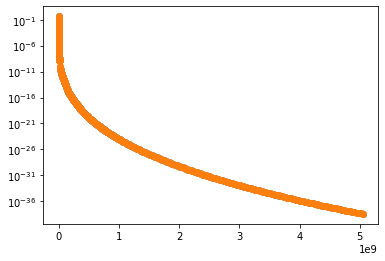

<Figure size 432x288 with 0 Axes>

In [5]:
plt.figure()
plt.semilogy(x**3,yy[:-2], '-o')
plt.semilogy(xx**3,yyy[:-2], '-o')
#plt.xlim(10,20)
#plt.ylim(10**-16,10**-6)
plt.figure()

In [99]:
#yyy[:-2]/yy[:-2]

In [7]:
def trapezoid(y_array,x_array):
    total = np.sum((x_array[1:]-x_array[:-1])*(y_array[1:]+y_array[:-1])/2)
    return total
meaned = trapezoid(yyy[:-2],xx)
maxed = trapezoid(yy[:-2],x)

In [8]:
print(meaned,maxed,meaned/maxed)

0.6958903616045968 0.6959038790467796 0.9999805757050797


In [9]:
original = trapezoid(aaa['fe'][200],aaa['e'][200])

In [10]:
print(original,meaned/original)

0.6957882308749997 1.0001467842154625


In [11]:
print(maxed/original)

1.0001662117389287


In [12]:
x=np.linspace(0,343,344)
ratio_mean=np.zeros(len(x))
ratio_max=np.zeros(len(x))
for i in range(len(aaa['e'])):
    eps = aaa['e'][i]
    y = np.zeros(len(eps)+2)
    y[:len(eps)]=aaa['fe'][i]
    y[-1]=aaa['temp'][i]
    y[-2]=aaa['time'][i]
    y_new,e = cv.simple_spread_eps(y,eps)
    y_maxed,e = cvv.simple_spread_eps(y,eps)
    y_trap = trapezoid(y_new[:-2],e)
    y_trap_max = trapezoid(y_maxed[:-2],e)
    ratio_mean[i]=y_trap/original
    ratio_max[i]=y_trap_max/original

<Figure size 432x288 with 0 Axes>

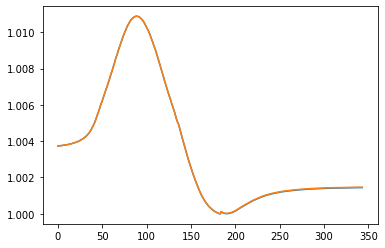

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure()
plt.plot(x,ratio_mean)
plt.plot(x,ratio_max)
#plt.xlim(50,150)
#plt.ylim(1,1.011)
plt.figure()

In [14]:

def epsilon_tester(l):
    eps = aaa['e'][l]
    y = np.zeros(len(eps)+2)
    y[:len(eps)]=aaa['fe'][l]
    y[-1]=aaa['temp'][l]
    y[-2]=aaa['time'][l]
    y_new,e_new = cv.simple_spread_eps(y,eps)
    y_maxed,e_max = cvv.simple_spread_eps(y,eps)
    
    print(y_new[31:37],y[31:37])
    print(e_new[31:37],eps[31:37])
    
    original = trapezoid(aaa['fe'][l],aaa['e'][l])
    y_trap = trapezoid(y_new[:-2],e_new)
    y_trap_max = trapezoid(y_maxed[:-2],e_max)
    #can print the above integrals if needed...
    
    plt.figure()
    plt.loglog(e_new,y_new[:-2]*e_new**3)
    plt.loglog(e_max,y_maxed[:-2]*e_max**3)
    plt.loglog(eps,aaa['fe'][l]*eps**3)
    #plt.xlim(50,200)
    #plt.ylim(10**-7,10**-1)
    plt.figure()

[2.90093996e-05 2.59452315e-05 2.33955913e-05 1.90796169e-05
 1.57463710e-05 1.31189189e-05] [2.90093996e-05 2.59452315e-05 2.33085177e-05 2.10200983e-05
 1.90194465e-05 1.72594764e-05]
[15.5 16.  17.  18.  19.  20. ] [15.5 16.  16.5 17.  17.5 18. ]


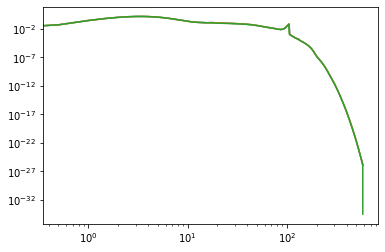

<Figure size 432x288 with 0 Axes>

In [15]:
epsilon_tester(135)

[5.14939444e-05 4.68013194e-05 4.46070621e-05 3.34656084e-05
 2.49438233e-05 1.91782293e-05] [5.14939444e-05 4.68013194e-05 4.63331426e-05 3.89606437e-05
 3.31772808e-05 2.85472283e-05]
[15.5 16.  18.  20.  22.  24. ] [15.5 16.  17.  18.  19.  20. ]


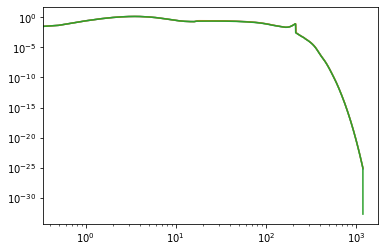

<Figure size 432x288 with 0 Axes>

In [16]:
epsilon_tester(183)

[6.17728151e-05 5.54470454e-05 5.51856069e-05 3.31157606e-05
 1.96370231e-05 1.25536172e-05] [6.17728151e-05 5.54470454e-05 6.09517921e-05 4.33917979e-05
 3.22169446e-05 2.46373551e-05]
[15.5 16.  20.  24.  28.  32. ] [15.5 16.  18.  20.  22.  24. ]


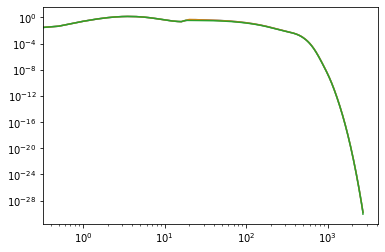

<Figure size 432x288 with 0 Axes>

In [17]:
epsilon_tester(334)

[6.18526429e-05 5.55132170e-05 5.52347029e-05 3.31346706e-05
 1.96448665e-05 1.25571528e-05] [6.18526429e-05 5.55132170e-05 6.10023964e-05 4.34208017e-05
 3.22346017e-05 2.46486772e-05]
[15.5 16.  20.  24.  28.  32. ] [15.5 16.  18.  20.  22.  24. ]


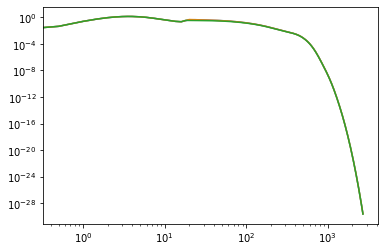

<Figure size 432x288 with 0 Axes>

In [18]:
epsilon_tester(335)

[1.85959976e-07 1.12798608e-07 7.27856167e-08 2.67802152e-08
 9.85331934e-09 3.62535936e-09] [1.85959976e-07 1.12798608e-07 6.84207756e-08 4.15023072e-08
 2.51742469e-08 1.52700597e-08]
[15.5 16.  17.  18.  19.  20. ] [15.5 16.  16.5 17.  17.5 18. ]


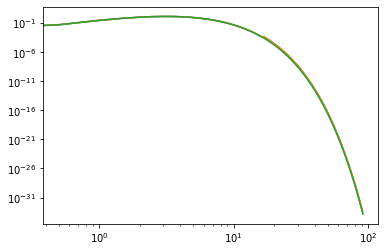

<Figure size 432x288 with 0 Axes>

In [19]:
epsilon_tester(16)

In [20]:
def find_ks(l):
    y=aaa['fe'][l]
    k=find_breaks(y)
    print(k,len(y))

In [21]:
for i in range(len(aaa['e'])):
    find_ks(i)

[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 116. 139.] 184
[ 93. 117. 140.] 184
[ 94. 117. 140.] 184
[ 95. 118. 14

In [31]:

@nb.jit(nopython=True)
# Note: j is an index, not a p-value
def C_round(j,f1,p):
    c,c_frs = coll.cI(j,f1,p)
    if abs(c/c_frs) < 3e-15:
        return 0
    else:
        return c


@nb.jit(nopython=True)
def smallgrid(p,f,k0,k1):
    boxsize = p[-1] - p[-2]
    p_small_boxsize = p[1] - p[0]
#    print(int(1.25*k0), p[int(k1)-1], p_small_boxsize,len(p),k1)
    N = max(int(np.round(p[int(k1)-1]/p_small_boxsize,0))+1, int(1.25*k0))
    p_small = np.zeros(N)
    f_small = np.zeros(N)
    
    x_int = np.zeros(6)
    y_int = np.zeros(6)
    
    for i in range(num_small_boxes):
        p_small[i] = p[i]
        f_small[i] = f[i]
    for i in range(num_small_boxes,N):
        p_small[i] = i * p_small_boxsize
        k = int(np.round((p_small[i]-p[num_small_boxes-1])/boxsize,0)) + num_small_boxes - 1
        if np.round((p_small[i] - p[num_small_boxes-1]) / boxsize, 5) % 1 == 0:
#        if (p_small[i] - p[num_small_boxes-1]) % boxsize == 0:
            f_small[i] = f[k]
        else:
            if k+3 < len(p):
                for j in range(6):
                    x_int[j] = p[k + j - 2]
                    y_int[j] = f[k + j - 2]
                    if y_int[j] < 0:
                        print ("smallgrid",x_int[j], y_int[j])
                        print (k+j-2, k0, k1)
                        print ("f = ", f)
            else:
                x_int[:] = p[-6:]
                y_int[:] = f[-6:]
            f_small[i] = np.exp(interp.lin_int(p_small[i],x_int,np.log(y_int)))
    return p_small, f_small

@nb.jit(nopython=True)
def biggrid(p,f,k1):
    boxsize = p[-1] - p[-2]
    p_small_boxsize = p[1] - p[0]
    new_small_boxes = int(np.round(p[num_small_boxes-1]/boxsize,0)) + 1
    N = new_small_boxes + int(k1 - num_small_boxes)
    
    p_big = np.zeros(N)
    f_big = np.zeros(N)
    
    mult = int(round(boxsize/p_small_boxsize,0))
#    print(mult, new_small_boxes, N)
    p_big[0] = p[0]
    f_big[0] = f[0]
    for i in range(1,new_small_boxes):
        p_big[i] = p[mult * i]
        f_big[i] = np.max(f[mult*(i-1)+1:mult*i+1])
    for i in range(new_small_boxes, N):
        p_big[i] = p[num_small_boxes + (i-new_small_boxes)]
        f_big[i] = f[num_small_boxes + (i-new_small_boxes)]
        
    return p_big, f_big

In [107]:
def C_short(p,f1,T,k):
    c = np.zeros(len(p))
    boxsize = p[-1] - p[-2]

    if k[0] == 0:
        p_smallgrid, f_smallgrid = smallgrid(p,f1,num_small_boxes,len(p))
        p_wholegrid, f_wholegrid = biggrid(p,f1,len(p))
        for i in nb.prange(1,len(p)-1):
 #       for i in range(1,len(p)-1):
            if i < num_small_boxes:
                c[i] = C_round(i, f_smallgrid, p_smallgrid)
            else:
                c[i] = C_round((i-num_small_boxes)*2 + num_small_boxes , f_smallgrid, p_smallgrid)
 #               c[i] = C_round(i-num_small_boxes+1+int(eps_small_box/boxsize),f_wholegrid,p_wholegrid)
    else:
        k0 = num_small_boxes
#        print(k0, k[1], k[2], len(p))
        p_smallgrid, f_smallgrid = smallgrid(p,f1,k0,k[1])
        p_biggrid, f_biggrid = biggrid(p,f1,k[2])
        p_wholegrid, f_wholegrid = biggrid(p,f1,len(p))
#        print(p_biggrid)
#        for i in range(1,len(p)-1):
        for i in nb.prange(1,len(p)-1):
            if i < k0:
                c[i] = C_round(i, f_smallgrid, p_smallgrid)
    #            c[i] = C_round(i,f1[:k[1]],p[:k[1]])
    #            c[i] += ve.cI(i, f1[:k[1]],p[:k[1]],T)
            elif i < k[1]:
                c[i] = C_round(i-num_small_boxes+1+int(np.round(p[num_small_boxes-1]/boxsize,0)), f_biggrid, p_biggrid)
    #            c[i] = C_round(i,f1[:k[2]],p[:k[2]])
    #            c[i] += ve.cI(i, f1[:k[2]],p[:k[2]],T)
            else:
                c[i] = C_round(i-num_small_boxes+1+int(np.round(p[num_small_boxes-1]/boxsize,0)),f_wholegrid,p_wholegrid)
    #            c[i] += ve.cI(i,f1,p,T)
    
    print('k=',k)
    print('y length=',len(f1))
    #print('smallgrid y=',f_smallgrid)
    #print('small ticks =',p_smallgrid)
    #print('biggrid y=',f_biggrid)
    #print('big ticks =',p_biggrid)
    #print('wholegrid y=',f_wholegrid)
    #print('whole ticks =',p_wholegrid)
    return c,p_smallgrid,f_smallgrid,p_biggrid,f_biggrid,p_wholegrid,f_wholegrid



In [108]:
aaa.files


['mass',
 'mixing',
 'lifetime',
 'neff',
 'scalefactors',
 'time',
 'temp',
 'Tcm',
 'e',
 'fe',
 'NumbDensityDist',
 'decayrate',
 'collisionrate',
 'n_p_rate',
 'p_n_rate']

In [109]:
def map_grids(step):
    y_test=aaa['fe'][step]
    a = aaa['scalefactors'][step]

    Tcm = 1/a #We mult this to e_array for p input in C_short??
    T=aaa['temp'][step]
    e_array=aaa['e'][step]
    time=aaa['time'][step]

    k_test=find_breaks(y_test)
    c,p_small,f_small,p_big,f_big,p_whole,f_whole=C_short(e_array,y_test,T,k_test)
    
    
    plt.figure()
    plt.loglog(p_small,f_small)
    plt.loglog(p_big,f_big,color='k')
    plt.loglog(p_whole,f_whole,color='r')
    #plt.xlim(1,100)
    #plt.ylim(10**-7,10**-1)
    plt.figure()

k= [343. 440. 536.]
y length= 676


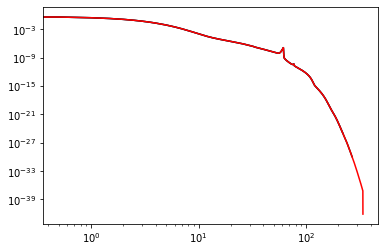

<Figure size 432x288 with 0 Axes>

In [110]:
map_grids(100)

In [125]:
def short_compar(step):
    e=aaa['e'][step]
    f=aaa['fe'][step]
    
    ms=aaa['mass']
    EB5 = ms/2
    EB2 = (ms**2 - mpi_neutral**2)/(2*ms)
    a0=aaa['scalefactors'][step]
    
    spread_f,spread_e=cv.simple_spread_eps(f,e)
    T=aaa['temp'][step]
    
    E5_index = np.where(e < EB5 * a0)[0][-1]
    E2_index = np.where(e < EB2 * a0)[0][-1]
    k_test=find_breaks(f,E5_index,E2_index)
    c,p_small,f_small,p_big,f_big,p_whole,f_whole=C_short(e,f,T,k_test)
    
    E5_index_sp = np.where(spread_e < EB5 * a0)[0][-1]
    E2_index_sp = np.where(spread_e < EB2 * a0)[0][-1]
    k_test_sp=find_breaks(spread_f,E5_index_sp,E2_index_sp)
    ci,p_small_sp,f_small_sp,p_big_sp,f_big_sp,p_whole_sp,f_whole_sp=C_short(spread_e,spread_f,T,k_test_sp)
    
    plt.figure()
    plt.plot(p_small,f_small)
    plt.plot(p_small_sp,f_small_sp,color='k')
    plt.yscale('log')
    plt.figure()
    
    print('EB5 index=',E5_index)
    print('EB2 index=',E2_index)
    print('spread EB5 index=',E5_index_sp)
    print('spread EB2 index=',E2_index_sp)

In [126]:
widgets.interact(short_compar, step=(0,343,8))

interactive(children=(IntSlider(value=168, description='step', max=343, step=8), Output()), _dom_classes=('wid…

<function __main__.short_compar(step)>

In [127]:
widgets.interact(short_compar, step=(40,60,1))

interactive(children=(IntSlider(value=50, description='step', max=60, min=40), Output()), _dom_classes=('widge…

<function __main__.short_compar(step)>